
# AIFFEL_Kaggle_Predict Future Sales

---

## Import

In [269]:
import os
import gc
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import re
from itertools import product
import time
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow
from tensorflow.keras.optimizers import Adam

import lightgbm as lgb



## Load Data

In [2]:
items=pd.read_csv("../data/items.csv")
shops=pd.read_csv("../data/shops.csv")
cats=pd.read_csv("../data/item_categories.csv")
train=pd.read_csv("../data/sales_train.csv")
test=pd.read_csv("../data/test.csv")

## Data cleaning

### outliers

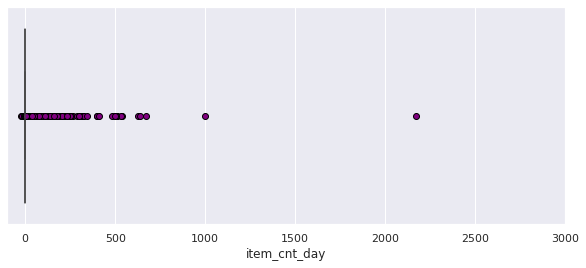

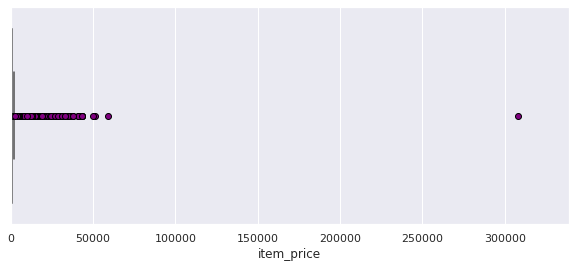

In [3]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

In [4]:
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]

In [5]:
# item_price, item_cnt_day이 0 보다 작은 것들 처리해줍니다.
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

### Shop Data

In [6]:
# shop_id 와 shop_name 이 맞지 않는 데이터 처리
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [7]:
# shop_name 통일시켜주기
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
# city 뽑아내기
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
# category 뽑아내기
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

In [8]:
# 특정한 shop category가 5개이상 이상있으면 other로 묶어준다.
category = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5:
        category.append(cat)
shops.category = shops.category.apply( lambda x: x if (x in category) else "other" )

In [9]:
# encoding해주기
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_id", "shop_category", "shop_city"]]

### Item Category Data

In [10]:
# 카테고리 type_code 분리해내기
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры"

In [11]:
# 특정한 카테고리 type_code가 5개이상 이상있으면 etc로 묶어준다.
category = []
for cat in cats.type_code.unique():
    if len(cats[cats.type_code == cat]) >= 5: 
        category.append( cat )
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")

In [12]:
# subtype 분리해내기
cats.type_code = LabelEncoder().fit_transform(cats.type_code)
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]

### Item Data

In [13]:
def name_correction(x):
    x = x.lower() # 소문자로 만들기
    x = x.partition('[')[0] # [ 기준 분리
    x = x.partition('(')[0] # ( 기준 분리
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # 특수문자 제거
    x = x.replace('  ', ' ') # 두칸짜리 공백 한칸으로
    x = x.strip() # 공백 제거
    return x

In [14]:
# [,( 기준으로 분리
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# 특수문자 공백으로 만들고 소문자로
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# Nan 값 0으로
items = items.fillna('0')

# name_correction 함수 적용
items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

# 0이 아닌 경우 뒤에오는 ], ) 제거
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

In [17]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

In [18]:
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


## Data Preprocessing

In [19]:
# (월, 가게, 아이템) 데이터프레임을 모든 경우를 조합해서 만든다.
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )

6.832607269287109

In [21]:
# 월별 판매량
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)

2.5161781311035156

In [27]:
# test 에 date_block_num 추가 (34 = 예측해야하는 달)
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

In [29]:
# matrix += test
matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )

0.03655719757080078

In [30]:
# matrix에 shops, items, cats 추가
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)

2.227229118347168

In [31]:
# lag : 이전 달들의 판매량
def lag_feature( df,lags, cols ):
    for col in cols:
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [32]:
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )

10.090244770050049

In [34]:
# 월별 팔린 평균 아이템 갯수, lag
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )

5.368463039398193

In [35]:
# 월별의 아이템별 팔린 평균 갯수, lag
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

13.005964279174805

In [36]:
# 월별의 가게에서 팔린 평균 아이템 갯수, lag
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


12.918829202651978

In [37]:
# 월별의 가게별 아이템 별 팔린 평균 아이템 갯수, lag
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


In [38]:
# 월별 , 가게별 서브카테고리별 팔린 아이템 평균 갯수, lag
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_shop_subtype_avg_item_cnt'])
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [39]:
# 월별 도시별 팔린 아이템 평균 갯수, lag
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [40]:
# 월별 아이템, 도시 단위 평균 아이템 팔린 갯수, lag
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [41]:
# 현재 달 기준, 지난 달의 특정 feature의 값이 전체 평균보다 높은지 낮은지 판단
# 지난달의 값이 없을 경우 최대 6개월 전까지 확인

# 전 기간동안 각 아이템 평균가격
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)

# 월별 아이템 평균가격
group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)

# 월별 각 1~3개월 전 평균 가격
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]
# 현재 달 기준 최근의 트렌드 찾는다.
# 1달전 없을 경우, 최대 3달전 까지 찾는다.
def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

# price trend를 찾은 후에는, 이전 lag들 drop
features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)

In [42]:
# revenue 추가
train["revenue"] = train["item_cnt_day"] * train["item_price"]

* Add total shop revenue per month to matix df. 
* Add lag values of revenue per month.
* Add delta revenue values - how current month revenue relates to global average.

In [43]:
# 가격 트렌드 처럼 총 수입 트렌드도 찾는다.
# 월별 각 가게 총 매출
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

# 전체 기간 각 가게 매출 평균
group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)

# 각 가게 월평균 매출 - 전체기간 평균 매출
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

# 한달전 총 매출
matrix = lag_feature(matrix, [1], ["delta_revenue"])

# 총매출 트랜드 찾은 후에 feature drop
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)

In [44]:
# month, days 추가
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

In [45]:
# 가게별 아이템 최초 판매 이후 개월
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')

# 아이템별 최초 판매 이후 개월
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')

In [46]:
# lag 값을 계산할 수 없는 3갠월 이전의 것들은 제거
matrix = matrix[matrix["date_block_num"] > 3]

In [48]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
            elif ('revenue' in col):
                df[col].fillna(0, inplace=True)
    return df

In [49]:
# Nan 값 0으로
matrix = fill_na(matrix)

In [50]:
matrix.head().T

,1497465,1497466,1497467,1497468,1497469
date_block_num,4.000000,4.000000,4.0,4.000000,4.000000
shop_id,2.000000,2.000000,2.0,2.000000,2.000000
item_id,27.000000,28.000000,29.0,30.000000,31.000000
item_cnt_month,0.000000,0.000000,0.0,0.000000,0.000000
shop_category,4.000000,4.000000,4.0,4.000000,4.000000
shop_city,0.000000,0.000000,0.0,0.000000,0.000000
item_category_id,19.000000,30.000000,23.0,40.000000,37.000000
name2,76.000000,107.000000,123.0,4.000000,4.000000
name3,42.000000,42.000000,42.0,42.000000,562.000000
subtype_code,10.000000,55.000000,16.0,4.000000,1.000000


## Train

In [51]:
# 데이터 저장
matrix.to_pickle('merona_final.pkl')

In [52]:
data = matrix.copy()
del matrix
gc.collect()

10066

In [3]:
data = pd.read_pickle('merona_final.pkl')

In [4]:
data[data["date_block_num"]==34].shape

(214200, 33)

In [5]:
# 0~32개월 : Train
# 33 개월 :  Validation
# 34 개월 :  Test
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [6]:
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [7]:
del data
gc.collect();

### XGB

In [8]:
model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

[11:14:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.17837	validation_1-rmse:1.11962
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.12711	validation_1-rmse:1.07985
[2]	validation_0-rmse:1.08286	validation_1-rmse:1.05012
[3]	validation_0-rmse:1.04689	validation_1-rmse:1.02256
[4]	validation_0-rmse:1.01504	validation_1-rmse:1.00064
[5]	validation_0-rmse:0.98669	validation_1-rmse:0.98242
[6]	validation_0-rmse:0.96292	validation_1-rmse:0.96912
[7]	validation_0-rmse:0.94429	validation_1-rmse:0.95893
[8]	validation_0-rmse:0.92605	validation_1-rmse:0.94786
[9]	validation_0-rmse:0.91143	validation_1-rmse:0.93980
[10]	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=10,
             min_child_weight=0.5, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [9]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

In [10]:
print('validation rmse:',np.sqrt(mean_squared_error(Y_valid, Y_pred)))

validation rmse: 0.8938829


### RandomForest

In [11]:
rf = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=7, n_estimators=50, n_jobs=-1, random_state=0)

In [12]:
rf_pred = rf.predict(X_valid).clip(0,20)
rf_test = rf.predict(X_test).clip(0, 20)

In [13]:
print('validation rmse:',np.sqrt(mean_squared_error(Y_valid, rf_pred)))

validation rmse: 0.9411875100713926


### LGBM

In [14]:
light = lgb.LGBMRegressor(learning_rate=0.1,
                         objective='regression',
                         metric='rmse',
                         num_leaves=2000,
                         verbose=1,
                         random_state=42,
                         bagging_fraction=0.7,
                         feature_fraction=0.5,
                         n_estimators=3000)

In [15]:
light.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

[1]	training's rmse: 1.15173	valid_1's rmse: 1.0925
Training until validation scores don't improve for 20 rounds
[2]	training's rmse: 1.09611	valid_1's rmse: 1.06001
[3]	training's rmse: 1.05227	valid_1's rmse: 1.03039
[4]	training's rmse: 1.01379	valid_1's rmse: 1.0038
[5]	training's rmse: 0.980782	valid_1's rmse: 0.98018
[6]	training's rmse: 0.946898	valid_1's rmse: 0.968777
[7]	training's rmse: 0.919708	valid_1's rmse: 0.957028
[8]	training's rmse: 0.897294	valid_1's rmse: 0.947056
[9]	training's rmse: 0.878423	valid_1's rmse: 0.937232
[10]	training's rmse: 0.858683	valid_1's rmse: 0.931227
[11]	training's rmse: 0.842282	valid_1's rmse: 0.92429
[12]	training's rmse: 0.828488	valid_1's rmse: 0.918481
[13]	training's rmse: 0.817022	valid_1's rmse: 0.917109
[14]	training's rmse: 0.806909	valid_1's rmse: 0.916407
[15]	training's rmse: 0.797922	valid_1's rmse: 0.912158
[16]	training's rmse: 0.786549	valid_1's rmse: 0.912092
[17]	training's rmse: 0.779178	valid_1's rmse: 0.910579
[18]	tra

LGBMRegressor(bagging_fraction=0.7, feature_fraction=0.5, metric='rmse',
              n_estimators=3000, num_leaves=2000, objective='regression',
              random_state=42, verbose=1)

In [16]:
light_pred = light.predict(X_valid).clip(0, 20)
light_test = light.predict(X_test).clip(0, 20)

In [17]:
print('validation rmse:',np.sqrt(mean_squared_error(Y_valid, light_pred)))

validation rmse: 0.9039015050501613


### Lasso

In [18]:
lso = Lasso(alpha=0.003)

In [19]:
lso.fit(X_train,Y_train)

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2177940.75, tolerance: 1358.58642578125
  positive)


Lasso(alpha=0.003)

In [20]:
lasso_pred = lso.predict(X_valid).clip(0, 20)
lasso_test = lso.predict(X_test).clip(0, 20)

In [21]:
print('validation rmse:',np.sqrt(mean_squared_error(Y_valid, lasso_pred)))

validation rmse: 1.0323138


### XGB + RF + LGBM + Lasso

In [38]:
Y_preds = pd.DataFrame(Y_pred, columns=['xgbm'])
rf_preds = pd.DataFrame(rf_pred, columns=['random_forest'])
light_preds = pd.DataFrame(light_pred, columns=['lgbm'])
lasso_preds = pd.DataFrame(lasso_pred, columns=['lasso'])

In [39]:
Y_tests = pd.DataFrame(Y_test, columns=['xgbm'])
rf_tests = pd.DataFrame(rf_test, columns=['random_forest'])
light_tests = pd.DataFrame(light_test, columns=['lgbm'])
lasso_tests = pd.DataFrame(lasso_test, columns=['lasso'])

In [40]:
Y_preds.to_pickle('merona_final_xgb_pred.pkl')
rf_preds.to_pickle('merona_final_rf_pred.pkl')
light_preds.to_pickle('merona_final_light_pred.pkl')
lasso_preds.to_pickle('merona_final_lasso_pred.pkl')

In [41]:
Y_tests.to_pickle('merona_final_xgb_test.pkl')
rf_tests.to_pickle('merona_final_rf_test.pkl')
light_tests.to_pickle('merona_final_light_test.pkl')
lasso_tests.to_pickle('merona_final_lasso_test.pkl')

In [29]:
first = pd.DataFrame(Y_pred, columns=['xgbm'])
first['random_forest'] = rf_pred
first['lgbm'] = light_pred
first['lasso'] = lasso_pred
first['label'] = Y_valid.values
first.head()

,xgbm,random_forest,lgbm,lasso,label
0,0.016044,0.032357,0.026478,0.064202,0.0
1,0.076978,0.210863,0.122977,0.018155,1.0
2,0.207642,0.089321,0.210888,0.145476,0.0
3,0.273158,0.243354,0.296206,0.190494,0.0
4,0.017241,0.032357,0.023437,0.000000,0.0


In [30]:
first_test = pd.DataFrame(Y_test, columns=['xgbm'])
first_test['random_forest'] = rf_test
first_test['lgbm'] = light_test
first_test['lasso'] = lasso_test
first_test.head()

,xgbm,random_forest,lgbm,lasso
0,0.321365,0.308961,0.519310,0.630460
1,0.360762,0.991942,1.126783,0.351951
2,0.983320,0.702257,0.809332,0.869099
3,0.489166,0.646894,0.409849,0.686034
4,3.778995,2.554509,3.167235,0.622310


In [31]:
final_model = LinearRegression(n_jobs=-1)

In [32]:
first.drop('label', axis=1, inplace=True)
final_model.fit(first, Y_valid)

LinearRegression(n_jobs=-1)

In [33]:
ensemble_pred = final_model.predict(first).clip(0, 20)

In [34]:
print('ensemble_pred rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_valid)))

ensemble_pred rmse: 0.8887673144571938


In [36]:
final_predictions = final_model.predict(first_test).clip(0, 20)

## Submission

In [37]:
prediction_df = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": final_predictions
})

prediction_df.to_csv('submission/merona_finalll_submission.csv', index=False)

## Train all

In [403]:
a = pd.read_pickle('../data/jy/lgbm_pred_earlystopping20 .pickle')
b = pd.read_pickle('../data/jy/xgb_pred_earlystopping20.pickle')
a_test = pd.read_pickle('../data/jy/lgbm_test_earlystopping20.pickle')
b_test = pd.read_pickle('../data/jy/xgb_test_earlystopping20.pickle')

In [404]:
c = pd.read_pickle('../data/jh/merona_final_lasso_pred.pkl')
d = pd.read_pickle('../data/jh/merona_final_light_pred.pkl')
e = pd.read_pickle('../data/jh/merona_final_rf_pred.pkl')
f = pd.read_pickle('../data/jh/merona_final_xgb_pred.pkl')

c_test = pd.read_pickle('../data/jh/merona_final_lasso_test.pkl')
d_test = pd.read_pickle('../data/jh/merona_final_light_test.pkl')
e_test = pd.read_pickle('../data/jh/merona_final_rf_test.pkl')
f_test = pd.read_pickle('../data/jh/merona_final_xgb_test.pkl')

In [405]:
g = pd.read_pickle('../data/sm/xgb_pred_0.901834.pickle')

g_test = pd.read_pickle('../data/sm/xgb_test_0.901834.pickle')

In [406]:
h = pd.read_pickle('../data/km/cat_pred_earlystopping20.pickle')
l = pd.read_pickle('../data/km/xgb_train.pickle')

h_test = pd.read_pickle('../data/km/cat_test_earlystopping20.pickle')
l_test = pd.read_pickle('../data/km/xgb_test.pickle')

In [407]:
i = pd.read_pickle('../data/jw/enet_train.pickle')
j = pd.read_pickle('../data/jw/gb_train.pickle')
k = pd.read_pickle('../data/jw/ridge_train.pickle')
m = pd.read_pickle('../data/jw/cnn_train.pickle')

i_test = pd.read_pickle('../data/jw/enet_test.pickle')
j_test = pd.read_pickle('../data/jw/gb_test.pickle')
k_test = pd.read_pickle('../data/jw/ridge_test.pickle')
m_test = pd.read_pickle('../data/jw/cnn_test.pickle')

In [408]:
print('ensemble_pred rmse:', np.sqrt(mean_squared_error(l, Y_valid)))

ensemble_pred rmse: 0.90106463


In [409]:
merona_final = pd.DataFrame(a, columns=['lgbma'])
merona_final['xgbb'] = b
merona_final['lassoc'] = c
merona_final['lightd'] = d
merona_final['random_foreste'] = e
merona_final['xgbf'] = f
merona_final['xgbg'] = g
merona_final['enet'] = i
merona_final['gb'] = j
merona_final['ridge'] = k
merona_final['cath'] = h
merona_final['xgbl'] = l
merona_final['cnnm'] = m




merona_final['label'] = Y_valid.values

In [410]:
merona_final.head()

,lgbma,xgbb,lassoc,lightd,random_foreste,xgbf,xgbg,enet,gb,ridge,cath,xgbl,cnnm,label
0,0.007008,0.057410,0.064202,0.026478,0.032357,0.016044,0.077088,-0.051175,0.036746,-0.139739,0.044362,0.036364,0.064270,0.0
1,0.068977,0.134304,0.018155,0.122977,0.210863,0.076978,0.150140,-0.096576,0.036746,-0.205290,0.067487,0.134667,0.053287,1.0
2,0.172749,0.239080,0.145476,0.210888,0.089321,0.207642,0.229257,0.156611,0.222806,0.089633,0.157758,0.222893,0.164733,0.0
3,0.269338,0.278302,0.190494,0.296206,0.243354,0.273158,0.280044,0.461344,0.036746,0.384009,0.288753,0.291044,0.158865,0.0
4,0.021194,0.057225,0.000000,0.023437,0.032357,0.017241,0.055767,0.005222,0.036746,0.039249,0.043296,0.043435,0.095849,0.0


In [411]:
merona_final_test = pd.DataFrame(a_test, columns=['lgbma'])
merona_final_test['xgbb'] = b_test
merona_final_test['lassoc'] = c_test
merona_final_test['lightd'] = d_test
merona_final_test['random_foreste'] = e_test
merona_final_test['xgbf'] = f_test
merona_final_test['xgbg'] = g_test
merona_final_test['enet'] = i_test
merona_final_test['gb'] = j_test
merona_final_test['ridge'] = k_test
merona_final_test['cath'] = h_test
merona_final_test['xgbl'] = l_test
merona_final_test['cnnm'] = m_test


In [412]:
merona_final_test.head()

,lgbma,xgbb,lassoc,lightd,random_foreste,xgbf,xgbg,enet,gb,ridge,cath,xgbl,cnnm
0,0.502092,0.618743,0.630460,0.519310,0.308961,0.321365,0.531180,0.523784,0.587816,0.477109,0.535232,0.805964,0.500905
1,0.518915,0.351434,0.351951,1.126783,0.991942,0.360762,0.449609,0.268891,0.626516,0.372890,0.453614,0.388562,0.979102
2,0.828657,1.054130,0.869099,0.809332,0.702257,0.983320,1.046538,1.180124,0.898983,1.145069,0.790038,1.159053,0.950385
3,0.591258,0.423872,0.686034,0.409849,0.646894,0.489166,0.489466,0.351571,0.712924,0.299848,0.373310,0.577076,0.344505
4,3.784111,4.200912,0.622310,3.167235,2.554509,3.778995,2.906148,0.279816,2.208564,0.394879,1.683883,4.457869,1.788661


### final is linear

In [413]:
final_modelsss = LinearRegression(n_jobs=-1)

In [414]:
merona_final.drop('label', axis=1, inplace=True)
final_modelsss.fit(merona_final, Y_valid)

LinearRegression(n_jobs=-1)

In [415]:
ensemble_predsssd = final_modelsss.predict(merona_final).clip(0, 20)

In [416]:
print('ensemble_pred rmse:', np.sqrt(mean_squared_error(ensemble_predsssd, Y_valid)))

ensemble_pred rmse: 0.8811864355620055


In [417]:
final_predictionssss = final_modelsss.predict(merona_final_test)

In [418]:
final_predictionssss.shape

(214200,)

In [419]:
final_predictionssss = final_modelsss.predict(merona_final_test).clip(0, 20)

### Real Submission 

In [420]:
prediction_df = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": final_predictionssss
})

prediction_df.to_csv('submission/merona_tes03t_submission.csv', index=False)

### final is deep

In [421]:
final_deep_x = merona_final.values
final_deep_x_test = merona_final_test.values

In [422]:
final_deep_x.shape

(238172, 13)

In [423]:
final_deep_x_test.shape

(214200, 13)

In [398]:
# merona_final.drop('label', axis=1, inplace=True)

In [424]:
final_deep = Sequential()
final_deep.add(Dense(64, input_dim = 13, activation='relu'))
final_deep.add(Dense(64, activation='relu'))
final_deep.add(Dense(1))

In [425]:
final_deep.compile(loss=tensorflow.keras.losses.mse,
                   optimizer=Adam(lr=0.007, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.9),
                  metrics=[tensorflow.keras.metrics.RootMeanSquaredError()])

In [426]:
final_deep.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [427]:
final_deep.fit(final_deep_x, Y_valid, epochs=30, batch_size=32)

Epoch 1/30
7443/7443 [==============================] - 8s 1ms/step - loss: 0.8004 - root_mean_squared_error: 0.8947
Epoch 2/30
7443/7443 [==============================] - 9s 1ms/step - loss: 0.7972 - root_mean_squared_error: 0.8928
Epoch 3/30
7443/7443 [==============================] - 9s 1ms/step - loss: 0.7965 - root_mean_squared_error: 0.8925
Epoch 4/30
7443/7443 [==============================] - 8s 1ms/step - loss: 0.7960 - root_mean_squared_error: 0.8922
Epoch 5/30
7443/7443 [==============================] - 8s 1ms/step - loss: 0.7957 - root_mean_squared_error: 0.8920
Epoch 6/30
7443/7443 [==============================] - 8s 1ms/step - loss: 0.7955 - root_mean_squared_error: 0.8919
Epoch 7/30
7443/7443 [==============================] - 8s 1ms/step - loss: 0.7953 - root_mean_squared_error: 0.8918
Epoch 8/30
7443/7443 [==============================] - 8s 1ms/step - loss: 0.7952 - root_mean_squared_error: 0.8917
Epoch 9/30
7443/7443 [==============================] - 8s 1ms/s

In [428]:
deep_pred = final_deep.predict(final_deep_x)

In [429]:
print('ensemble_pred rmse:', np.sqrt(mean_squared_error(deep_pred, Y_valid)))

ensemble_pred rmse: 0.890904


In [430]:
deep_predictionssss = final_deep.predict(final_deep_x_test).clip(0, 20)

In [431]:
deep_predictionssss = deep_predictionssss.squeeze()

In [432]:
deep_predictionssss

array([0.5393479 , 0.43467802, 0.99005055, ..., 0.06512672, 0.02245909,
       0.045017  ], dtype=float32)

In [433]:
prediction_df = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": deep_predictionssss
})

prediction_df.to_csv('submission/merona_finaldep2_submission.csv', index=False)